In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
from vnstock import *

In [21]:
vn = pd.read_csv("vn_price.csv", index_col="TradingDate", parse_dates=True)

In [22]:
vn.columns

Index(['AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT', 'ACB', 'ACC', 'ACG', 'ACL',
       ...
       'VPS', 'VRC', 'VRE', 'VSC', 'VSH', 'VSI', 'VTB', 'VTO', 'YBM', 'YEG'],
      dtype='object', length=406)

In [49]:
start = "2019-01-01"
end = "2023-03-31"
df = vn[(pd.Timestamp(start).date()<=vn.index.date)&(vn.index.date<=pd.Timestamp(end).date())][["VIC","YEG"]]

In [50]:
df

,VIC,YEG
TradingDate,,
2019-01-02,89246.0,238000.0
2019-01-03,89157.0,238000.0
2019-01-04,89423.0,238000.0
2019-01-07,89779.0,235000.0
2019-01-08,89779.0,249900.0
...,...,...
2023-02-24,52900.0,10600.0
2023-02-27,52500.0,10000.0
2023-02-28,52600.0,10400.0


a) Tính chuỗi dữ liệu về Tỷ suất lợi nhuận theo phương pháp liên tục

In [51]:
ti_suat = np.log(df/df.shift(1))

In [52]:
ti_suat.dropna(inplace=True)
ti_suat

,VIC,YEG
TradingDate,,
2019-01-03,-0.000998,0.000000
2019-01-04,0.002979,0.000000
2019-01-07,0.003973,-0.012685
2019-01-08,0.000000,0.061475
2019-01-09,0.004933,-0.071741
...,...,...
2023-02-24,-0.001889,-0.063949
2023-02-27,-0.007590,-0.058269
2023-02-28,0.001903,0.039221


b) Lấy thông tin về Thống kê mô tả của hai chuỗi Tỷ suất lợi nhuận nói trên trong Excel

In [53]:
ti_suat.describe()

,VIC,YEG
count,1038.000000,1038.000000
mean,-0.000509,-0.002988
std,0.018448,0.035873
min,-0.072567,-0.072571
25%,-0.007664,-0.020001
50%,0.000000,-0.002094
75%,0.005625,0.013971
max,0.067601,0.067659


c) Lập danh mục đầu tư hai cổ phiếu với Tỷ trọng thay đổi.  Tính Tỷ suất lợi nhuận của danh mục theo hai cách : trực tiếp và gián tiếp.

Danh mục

In [54]:
weights = df.div(df.abs().sum(axis=1), axis=0)

In [55]:
weights.shift(1)

,VIC,YEG
TradingDate,,
2019-01-02,NaN,NaN
2019-01-03,0.272718,0.727282
2019-01-04,0.272521,0.727479
2019-01-07,0.273112,0.726888
2019-01-08,0.276431,0.723569
...,...,...
2023-02-24,0.824261,0.175739
2023-02-27,0.833071,0.166929
2023-02-28,0.840000,0.160000


In [56]:
ti_suat_danh_muc = np.sum(weights.shift(1)*ti_suat,axis=1)

d) Kiểm chứng tính chuẩn của Tỷ suất lợi nhuận các cổ phiếu và danh mục.

In [57]:
from scipy.stats import jarque_bera
jb_value_VIC, p_value_VIC = jarque_bera(ti_suat["VIC"])
jb_value_YEG, p_value_YEG = jarque_bera(ti_suat["YEG"])
jb_value_port, p_value_port = jarque_bera(ti_suat_danh_muc)

In [58]:
print(f"VIC p_value: {p_value_VIC}")
print(f"YEG p_value: {p_value_YEG}")
print(f"Portfolio p_value: {p_value_port}")

VIC p_value: 1.804157353376481e-162
YEG p_value: 0.8053798650910625
Portfolio p_value: 9.63691946346989e-49


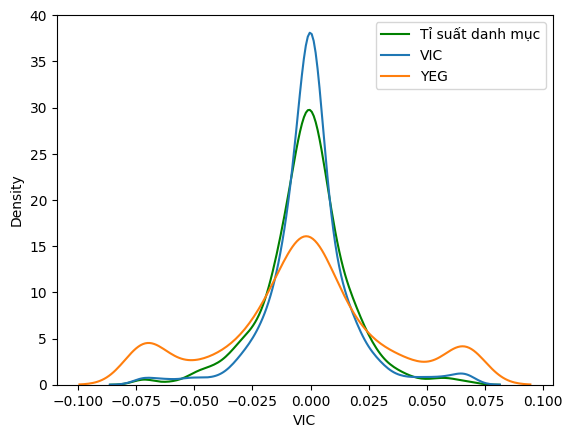

In [59]:
sns.kdeplot(ti_suat_danh_muc,color="green",label="Tỉ suất danh mục")
sns.kdeplot(ti_suat["VIC"],label="VIC")
sns.kdeplot(ti_suat["YEG"],label="YEG")
plt.legend()

Vậy YEG phân phối chuẩn

e) Giả sử có một trong 3 chuỗi trên phân phối chuẩn hãy viết Phương trình động thái giá (hoặc danh mục) theo mô hình chuyển động Brown hình học.

Giả sử mô hình chuyển động của giá là $S(t)=S(0)e^{\sigma B_t+(\mu-\frac12 \sigma^2)t}$
#### Ước lượng $\mu$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr E(r)=E(\frac{dS_t}{S_t})=E(\mu dt+\sigma dB_t)\\
&\Rarr E(r)=E(\mu dt)+E(\sigma dB_t)\\
&\Rarr E(r)=\mu E(dt)\\
&\Rarr \frac{E(r)}{dt}=\mu
\end{aligned}
$$

#### Ước lượng $\sigma$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr V(r)=V(\frac{dS_t}{S_t})=V(\mu dt+\sigma dB_t)\\
&\Rarr V(r)=V(\mu dt)+V(\sigma dB_t)\\
&\Rarr V(r)=\sigma^2 \times dt\\
&\Rarr \sqrt{\frac{V(r)}{dt}}=\sigma
\end{aligned}
$$

In [60]:
def mu_sigma(tisuat,hs):
    mu = (tisuat.mean())*hs
    sigma = np.sqrt(tisuat.var()*hs)
    return mu, sigma

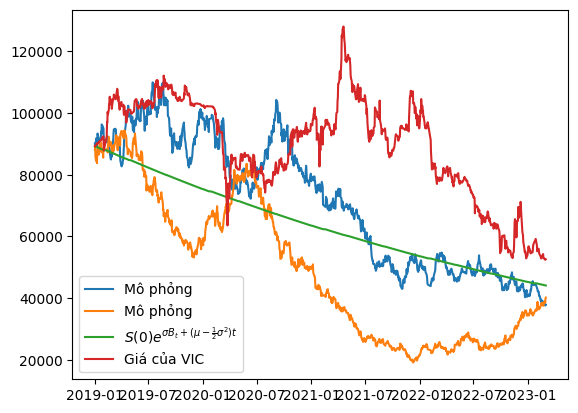

In [65]:
ticker = "VIC"
mu, sigma =  mu_sigma(ti_suat[ticker],len(ti_suat))

T=1
N=len(df) # Số bước 
M=10000 # Số kịch bản

dt=T/N
t=np.arange(0,1,dt)
dW = np.sqrt(dt)*np.random.randn(M,N)
W = np.cumsum(dW,axis=1)
S0 = df[ticker][0]

U=np.exp((mu-0.5*sigma**2)*t+sigma*W)
Umean = np.exp((mu-0.5*sigma**2)*t)

plt.plot(df.index,S0*U[:2].T,label="Mô phỏng") #Vẽ 2 đường
plt.plot(df.index,S0*Umean,label="$S(0)e^{\sigma B_t+(\mu-\\frac{1}{2} \sigma^2)t}$")
plt.plot(df[ticker],label=f"Giá của {ticker}")
plt.legend()
plt.show()

In [16]:
df[['r_VIC','r_YEG']]=ti_suat
df[["a_VIC","a_YEG"]]=weights
df["returns"]=(weights.shift(1)*ti_suat).sum(axis=1)
df[['Br1','Br2','Br3']]=pd.DataFrame(U.T,index=df.index)[[1,2,3]]
df

,VIC,YEG,r_VIC,r_YEG,a_VIC,a_YEG,returns,Br1,Br2,Br3
TradingDate,,,,,,,,,,
2023-01-03,56800.0,9350.0,NaN,NaN,0.858655,0.141345,0.000000,0.980858,1.002099,0.994014
2023-01-04,56000.0,9350.0,-0.014185,0.000000,0.856924,0.143076,-0.012180,0.976754,0.989989,1.017181
2023-01-05,56200.0,8700.0,0.003565,-0.072053,0.865948,0.134052,-0.007254,0.973697,0.973583,1.018160
2023-01-06,56100.0,8890.0,-0.001781,0.021604,0.863210,0.136790,0.001354,0.989633,0.968202,1.010479
2023-01-09,55000.0,8720.0,-0.019803,-0.019308,0.863151,0.136849,-0.019735,0.976926,0.969430,0.995132
2023-01-10,54500.0,8620.0,-0.009132,-0.011534,0.863435,0.136565,-0.009461,0.989357,0.967490,1.004065
2023-01-11,55100.0,8600.0,0.010949,-0.002323,0.864992,0.135008,0.009137,0.976727,0.972689,1.009295
2023-01-12,55000.0,8700.0,-0.001817,0.011561,0.863422,0.136578,-0.000010,0.978017,0.960776,1.006700
2023-01-13,55000.0,8640.0,0.000000,-0.006920,0.864236,0.135764,-0.000945,0.962529,0.940327,1.003994


In [18]:
df.to_csv("k1.csv")